### Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import math
import numpy as np
import  wandb
import os
import time

from torchmetrics import Dice
import segmentation_models_pytorch as smp
from loss.loss import Criterion

## depend to the files of the project
import utils 
from utils import load, save, plot
from benchmark import dataset
from methods import unet, unetplusplus, deeplab, transunet
from utils import load, save, plot

### Loading the WandB

In [2]:
key_file = './wandb-key.txt'

if os.path.exists(key_file):
    with open(key_file) as f:
        key = f.readline().strip()
    wandb.login(key=key)
else:
    print("Key file does not exist. Please create the key file with your wandb API key.")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sepehr-eslami2019 (face-estimation). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\USER/.netrc


### Arguments

In [14]:
seed = 3
wandb_enable = True

info = {'num_epoch' :5,
        'lr' : 0.01,
        'weight_decay' : 0.0001,
        'device' : 'cuda',
        'reset': True,
        'name_load' : 'tranunet(BCE&Tversky)',
        'model_load_path' : './saved_model/',
        'model_save_path' : './saved_model/'
        }


Initialize `wandb`

In [4]:
wandb_arg_name = 'TransUnet' # name of this training process
wandb.init(
        project='Medical Image Segmentation(BCE&Tversky)',  # name of the project
        name=wandb_arg_name,
        config={
            'lr': info['lr'],
            'weight_decay': info['weight_decay'],
            'num_epoch': info['num_epoch']
        }
    )


### Main Loop

In [5]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

Deffine the `Dataloader`

In [6]:
train_batch_size = 24
valid_batch_size = 42

train_loader = dataset.UW_madison(root='./benchmark/UW_madison_dataset', mode='train', mini=False, memory=True)(batch_size=train_batch_size)
valid_loader = dataset.UW_madison(root='./benchmark/UW_madison_dataset', mode='valid', mini=False, memory=False)(batch_size=valid_batch_size)

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


 Define the `Model` - `Optimizer` - `Loss Function` - `Metric`

In [7]:
load_path = info['model_load_path'] + info['name_load'] + ".pth"

###############
#    Model    #
###############

# model = unet.UNet(n_channels=3, n_classes=3, bilinear=False).to(info['device'])  ## my unet arhitesture
# model = unet.pre_train_unet(encoder_name='efficientnet-b1').to(info['device'])  ## Pre-trained unet with efficientnet encoder
# model = unetplusplus.UnetPlusPlus(encoder_name='resnet18').to(info['device'])  ## Pre-trained unet++ archoteture with efficientnet encoder 
# model = deeplab.DeepLab(encoder_name='efficientnet-b1').to(info['device'])  ## Pre-trained DeepLabv3 archoteture with efficientnet encoder 
model = transunet.TransUNet(img_dim=224, in_channels=3, class_num=3).to(info['device'])


optimizer = optim.SGD(model.parameters(), lr=info['lr'], weight_decay=info['weight_decay'], momentum=0.9)# , nesterov=True
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6], gamma=0.5)

# loss_fn = smp.losses.DiceLoss(mode='multilabel')
loss_fn = Criterion()

metric = Dice().to(info['device'])

model, loss_fn, _ = load(model, loss_fn, optimizer, device=info['device'], reset = info['reset'], load_path = load_path)

save_path = info['model_save_path'] + info['name_load']+ ".pth"

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.03, weight_decay=info['weight_decay'], momentum=0.9)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=int(30000/32*10)+50, 
#                                                    eta_min=1e-6) 

**`Training`**

In [16]:
epochs = info['num_epoch']

for epoch in range(1, epochs+1):
    ## Train
    model, loss_train, metric_train = utils.train_one_epoch(model,
                                                            # valid_loader,
                                                            train_loader,
                                                            loss_fn,
                                                            optimizer,
                                                            metric,
                                                            epoch,
                                                            device=info['device'])
    
    ## Validation
    loss_valid, metric_valid = utils.evaluate(model,
                                              valid_loader,
                                              loss_fn,
                                              metric,
                                              device=info['device'])

        
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)


    print(f'Train      - Loss:{loss_train}  Metric:{metric_train}')
    print(f'Validation - Loss:{loss_valid}  Metric:{metric_valid}')
    print(f'LR = {lr_scheduler.get_last_lr()[0]}')
    print()

    if loss_valid < best_loss_valid:
        save(save_path, model, optimizer, loss_fn)
        best_loss_valid = loss_valid
        print('Model Saved ("o")')

    if wandb_enable:
        wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                   "metric_valid": metric_valid, "loss_valid": loss_valid})
        
    lr_scheduler.step()

    epoch_counter += 1





  0%|          | 0/502 [00:00<?, ?batch/s]

Epoch 1: 100%|██████████| 502/502 [08:06<00:00,  1.03batch/s, loss=0.151, metric=0.735] 


Train      - Loss:0.15079857409000397  Metric:0.7348741292953491
Validation - Loss:0.18582719564437866  Metric:0.672795832157135
LR = 0.2



Epoch 2: 100%|██████████| 502/502 [08:06<00:00,  1.03batch/s, loss=0.125, metric=0.778]


Train      - Loss:0.12481240928173065  Metric:0.778124213218689
Validation - Loss:0.1739303469657898  Metric:0.691597580909729
LR = 0.2



Epoch 3: 100%|██████████| 502/502 [10:14<00:00,  1.22s/batch, loss=0.113, metric=0.798]


Train      - Loss:0.11341783404350281  Metric:0.7975677251815796
Validation - Loss:0.16029947996139526  Metric:0.7191603779792786
LR = 0.2



Epoch 4: 100%|██████████| 502/502 [11:12<00:00,  1.34s/batch, loss=0.109, metric=0.805]


Train      - Loss:0.10909377038478851  Metric:0.8052688241004944
Validation - Loss:0.16490979492664337  Metric:0.7119412422180176
LR = 0.2



Epoch 5: 100%|██████████| 502/502 [11:14<00:00,  1.34s/batch, loss=0.108, metric=0.806]


Train      - Loss:0.10849557816982269  Metric:0.8059871792793274
Validation - Loss:0.1608208864927292  Metric:0.7184349298477173
LR = 0.2



In [41]:
wandb.finish()

loss_train,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss_valid,█▇█▃▃▄▃▂▂▃▂▂▃▁▃▂▂▂▂▄▁▁▁▁▁▁▁▁▁▁
metric_train,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
metric_valid,▂▂▁▆▆▅▆▇▇▅▇▇▇█▆▇▇▇▇▅██████████
loss_train,0.06232
loss_valid,0.11595
metric_train,0.88952
metric_valid,0.79693


In [10]:
save(save_path, model, optimizer, loss_fn)

### Plot learning curves


Trained 21 epochs


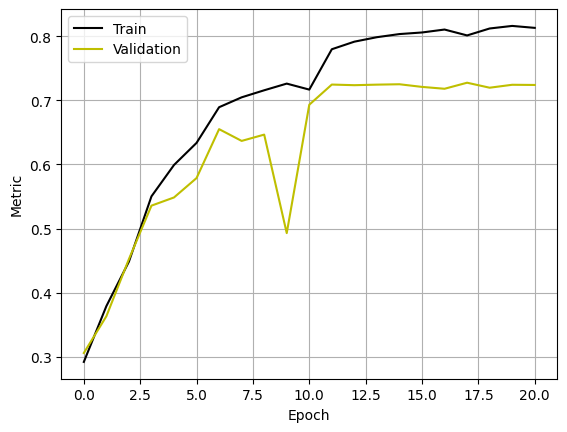


Trained 21 epochs


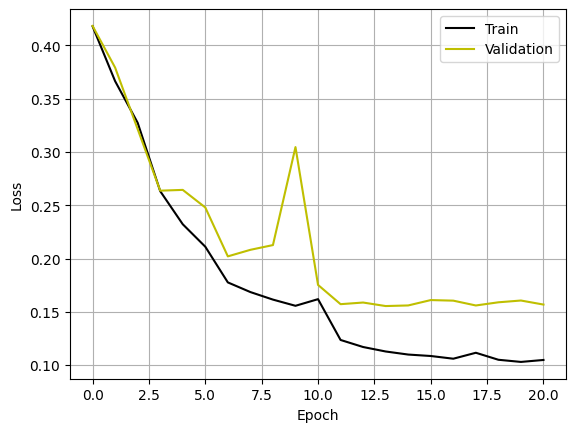

In [12]:
plot(metric_train_hist, metric_valid_hist, "Metric")
plot(loss_train_hist, loss_valid_hist, 'Loss')